## Denoising Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained DMAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [8]:
import sys
import os
import requests

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

sys.path.append('..')

import models_dmae

### Define utils

In [26]:
# define the utils

from pickle import FALSE

imagenet_mean = np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3)
imagenet_std = np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3)

def show_image(image, title='', normalized=True):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    if normalized:  # unnormalization
        image = image * imagenet_std + imagenet_mean
    plt.imshow(torch.clip(image * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='dmae_vit_large_patch16'):
    # build model
    model = getattr(models_dmae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model, sigma=0.25, mask_ratio=0.75):
    noise = torch.randn_like(img) * sigma
    perturbed_img = img + noise

    # make it a batch-like
    x = perturbed_img.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run DMAE
    x = (x - model.mean) / model.std
    latent, mask, ids_restore = model.forward_encoder(x.float(), mask_ratio)
    y = model.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
    loss = model.forward_loss(x, y, mask)

    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = perturbed_img * (1 - mask)

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(img, "original", normalized=False)

    plt.subplot(1, 4, 2)
    show_image(perturbed_img, "perturbed", normalized=False)

    plt.subplot(1, 4, 3)
    show_image(im_masked[0], "perturbed+masked", normalized=False)

    plt.subplot(1, 4, 4)
    show_image(y[0], "reconstruction")

    plt.show()

### Load an image

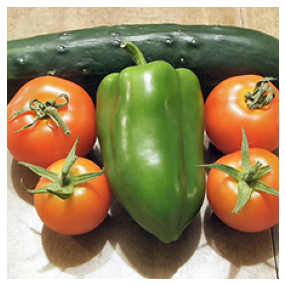

In [16]:
# load an image
# img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = torch.tensor(np.array(img) / 255.)

assert img.shape == (224, 224, 3)

plt.rcParams['figure.figsize'] = [5, 5]
show_image(img, normalized=False)

### Load a pre-trained MAE model

In [13]:
# This is an DMAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# !wget -nc --TODO--

chkpt_dir = '../dmae_visualize_vit_large.pth'
model_dmae = prepare_model(chkpt_dir, 'dmae_vit_large_patch16')
print('Model loaded.')


<All keys matched successfully>
Model loaded.


### Run DMAE on the image

DMAE with pixel reconstruction:


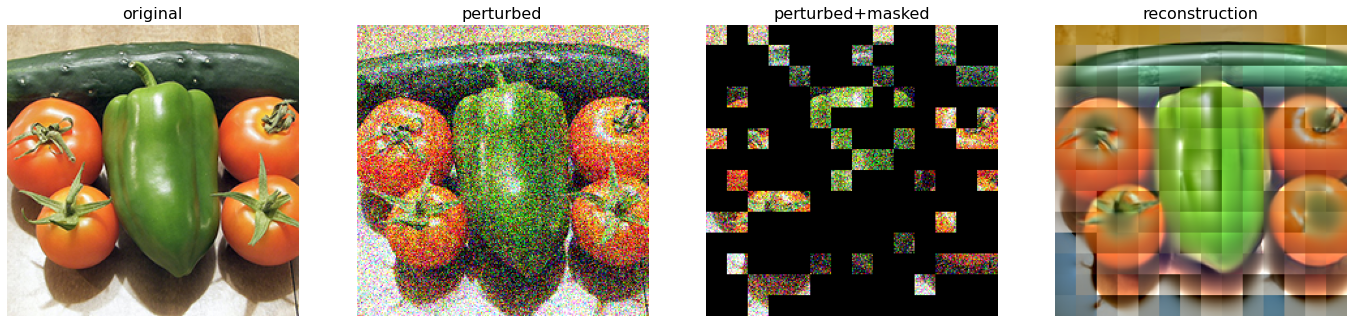

In [28]:
# fix the random seed: make random mask reproducible
torch.manual_seed(2)

sigma = 0.25  # noise scale
mask_ratio = 0.75

print('DMAE with pixel reconstruction:')
run_one_image(img, model_dmae, sigma=sigma, mask_ratio=mask_ratio)